In [1]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from glob import glob
import os
import numpy as np

In [3]:
root = '/home/jupyter/mnt/datasets/k_hairstyle_full/'
rel_dirs = [
    f'partition{i}/images'
    for i in range(1, 23)
]
rel_paths = []
for rel_dir in rel_dirs:
    rel_paths.extend([os.path.join(rel_dir, file) for file in os.listdir(os.path.join(root, rel_dir))])

In [4]:
annot = pd.read_pickle('/home/jupyter/mnt/datasets/k_hairstyle/annotation.pkl')

In [5]:
annot.shape, len(rel_paths)

((500000, 22), 500000)

In [7]:
paths = annot.path.tolist()
colors = annot.color.tolist()
unique_colors = set(colors)
color2idx = {
    color: idx
    for idx, color in enumerate(unique_colors)
}
idx2color = {
    idx: color
    for color, idx in color2idx.items()
}
labels = np.array([color2idx[color] for color in colors])

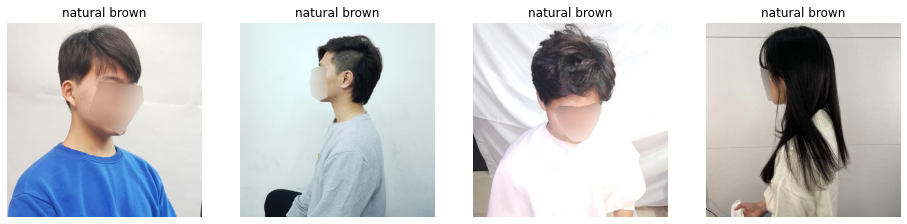

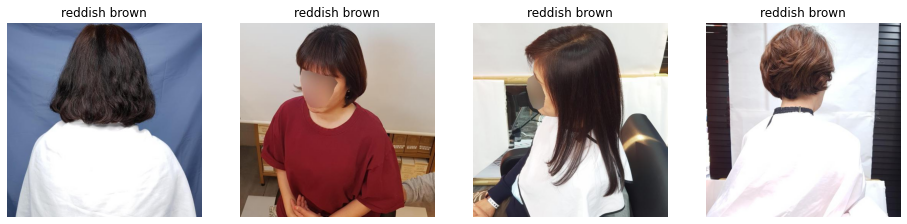

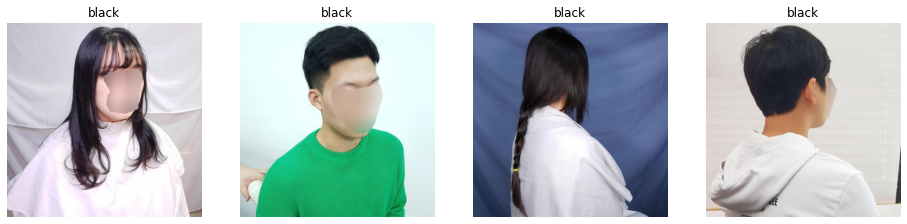

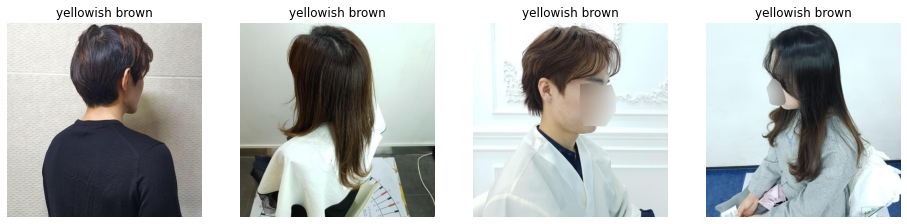

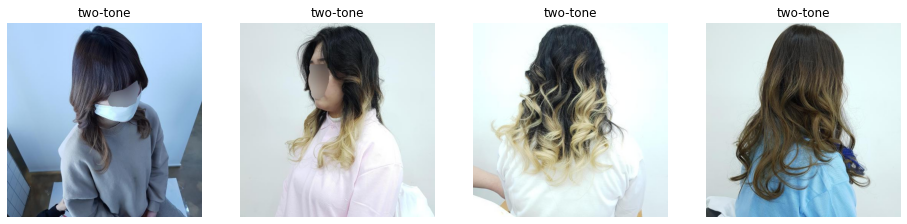

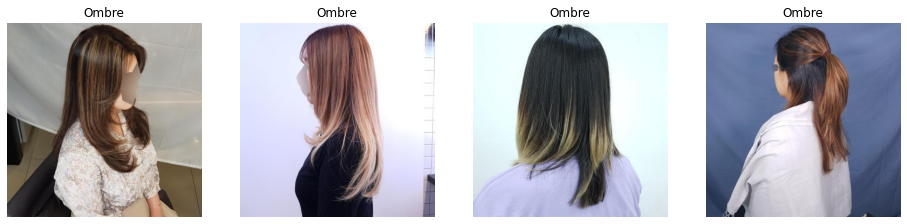

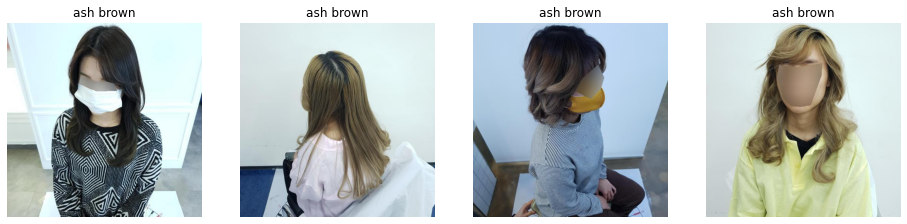

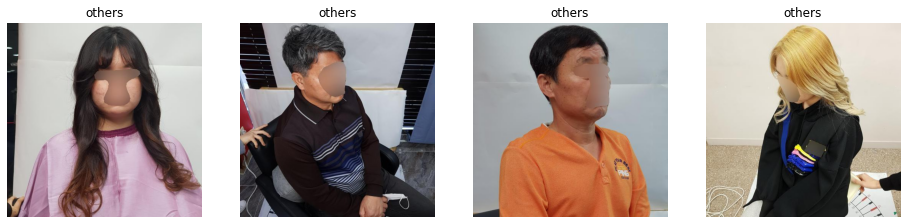

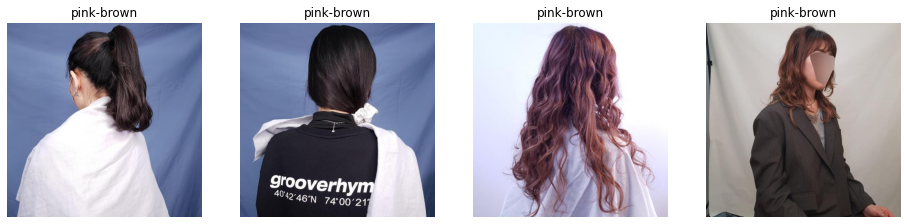

In [9]:
def showImagesHorizontally(images, figsize=(16, 16), title=None):
    fig = plt.figure(figsize=figsize)
    for i in range(len(images)):
        a = fig.add_subplot(1, len(images), i + 1)
        image = images[i]
        if title is not None:
            plt.title(title)
        plt.imshow(image)
        plt.axis('off')
    plt.show()
    

def get_random_image(paths, labels, label):
    inds = np.where(labels == label)[0]
    idx = np.random.choice(inds)
    path = paths[idx]
    abs_path = os.path.join(root, path)
    image = Image.open(abs_path).convert('RGB')
    return image


for label in range(len(unique_colors)):
    images = [get_random_image(paths, labels, label) for _ in range(4)]
    showImagesHorizontally(images, title=idx2color[label])

In [14]:
for idx, count in enumerate(np.bincount(labels)):
    print(idx2color[idx], count)

natural brown 111430
reddish brown 74363
black 157791
yellowish brown 66994
two-tone 10996
Ombre 13719
ash brown 12213
others 49415
pink-brown 3079


In [15]:
%pip install munch

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


In [23]:
df = annot[(annot.color != 'two-tone') & (annot.color != 'others')]
df = df.sample(frac=1)

paths = df.path.tolist()
colors = df.color.tolist()

unique_colors = set(colors)

color2idx = {
    color: idx
    for idx, color in enumerate(unique_colors)
}

idx2color = {
    idx: color
    for color, idx in color2idx.items()
}

labels = np.array([color2idx[color] for color in colors])

In [30]:
files = np.array([os.path.join(root, path) for path in paths])

In [36]:
import random

In [41]:
num_domains = labels.max() + 1

fnames, fnames2, targets = [], [], []

for label in range(num_domains):
    mask = labels == label
    label_files = files[mask]
    fnames += random.sample(label_files.tolist(), sum(mask))
    fnames2 += random.sample(fnames, sum(mask))
    targets += [label] * sum(mask)


In [46]:
from pathlib import Path
from itertools import chain
import os
import random

from munch import Munch
from PIL import Image
import numpy as np

import torch
from torch.utils import data
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision import transforms
from torchvision.datasets import ImageFolder

In [57]:
class ReferenceDataset(data.Dataset):
    def __init__(self, files, labels, transform=None):
        self.samples, self.targets = self._make_dataset(files, labels)
        self.transform = transform

    def _make_dataset(self, files, labels):
        num_domains = labels.max() + 1
        fnames, fnames2, targets = [], [], []
        for label in range(num_domains):
            mask = labels == label
            label_files = files[mask]
            fnames += random.sample(label_files.tolist(), sum(mask))
            fnames2 += random.sample(fnames, sum(mask))
            targets += [label] * sum(mask)
        return list(zip(fnames, fnames2)), labels

    def __getitem__(self, index):
        fname, fname2 = self.samples[index]
        label = self.targets[index]
        img = Image.open(fname).convert('RGB')
        img2 = Image.open(fname2).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
            img2 = self.transform(img2)
        return img, img2, label

    def __len__(self):
        return len(self.targets)

In [58]:
%%time
dataset = ReferenceDataset(files, labels)

CPU times: user 16.9 s, sys: 64 ms, total: 17 s
Wall time: 16.9 s


In [68]:
"""
StarGAN v2
Copyright (c) 2020-present NAVER Corp.

This work is licensed under the Creative Commons Attribution-NonCommercial
4.0 International License. To view a copy of this license, visit
http://creativecommons.org/licenses/by-nc/4.0/ or send a letter to
Creative Commons, PO Box 1866, Mountain View, CA 94042, USA.
"""

from pathlib import Path
from itertools import chain
import os
import random

from munch import Munch
from PIL import Image
import numpy as np

import torch
from torch.utils import data
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision import transforms
from torchvision.datasets import ImageFolder


def listdir(dname):
    fnames = list(chain(*[list(Path(dname).rglob('*.' + ext))
                          for ext in ['png', 'jpg', 'jpeg', 'JPG']]))
    return fnames


class DefaultDataset(data.Dataset):
    def __init__(self, files, transform=None):
        self.samples = files#listdir(root)
#         self.samples.sort()
        self.transform = transform
        self.targets = None

    def __getitem__(self, index):
        fname = self.samples[index]
        img = Image.open(fname).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        return img

    def __len__(self):
        return len(self.samples)


class DefaultLabeledDataset(data.Dataset):
    def __init__(self, files, labels, transform=None):
        self.samples = files#listdir(root)
        self.transform = transform
        self.targets = labels

    def __getitem__(self, index):
        fname = self.samples[index]
        target = self.targets[index]
        img = Image.open(fname).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        return img, target

    def __len__(self):
        return len(self.samples)


class ReferenceDataset(data.Dataset):
    def __init__(self, files, labels, transform=None):
        self.samples, self.targets = self._make_dataset(files, labels)
        self.transform = transform

    def _make_dataset(self, files, labels):
        num_domains = labels.max() + 1
        fnames, fnames2, targets = [], [], []
        for label in range(num_domains):
            mask = labels == label
            label_files = files[mask]
            fnames += random.sample(label_files.tolist(), sum(mask))
            fnames2 += random.sample(fnames, sum(mask))
            targets += [label] * sum(mask)
        return list(zip(fnames, fnames2)), labels

    def __getitem__(self, index):
        fname, fname2 = self.samples[index]
        label = self.targets[index]
        img = Image.open(fname).convert('RGB')
        img2 = Image.open(fname2).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
            img2 = self.transform(img2)
        return img, img2, label

    def __len__(self):
        return len(self.targets)


def _make_balanced_sampler(labels):
    class_counts = np.bincount(labels)
    class_weights = 1. / class_counts
    weights = class_weights[labels]
    return WeightedRandomSampler(weights, len(weights))


def get_train_loader(files, labels, which='source', img_size=256,
                     batch_size=8, prob=0.5, num_workers=4):
    print('Preparing DataLoader to fetch %s images '
          'during the training phase...' % which)

    crop = transforms.RandomResizedCrop(
        img_size, scale=[0.8, 1.0], ratio=[0.9, 1.1])
    rand_crop = transforms.Lambda(
        lambda x: crop(x) if random.random() < prob else x)

    transform = transforms.Compose([
        rand_crop,
        transforms.Resize([img_size, img_size]),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                             std=[0.5, 0.5, 0.5]),
    ])

    if which == 'source':
        dataset = DefaultLabeledDataset(files, labels, transform)
    elif which == 'reference':
        dataset = ReferenceDataset(files, labels, transform)
    else:
        raise NotImplementedError

    sampler = _make_balanced_sampler(dataset.targets)
    return data.DataLoader(dataset=dataset,
                           batch_size=batch_size,
                           sampler=sampler,
                           num_workers=num_workers,
                           pin_memory=True,
                           drop_last=True)


def get_eval_loader(files, img_size=256, batch_size=32,
                    imagenet_normalize=True, shuffle=True,
                    num_workers=4, drop_last=False):
    print('Preparing DataLoader for the evaluation phase...')
    if imagenet_normalize:
        height, width = 299, 299
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
    else:
        height, width = img_size, img_size
        mean = [0.5, 0.5, 0.5]
        std = [0.5, 0.5, 0.5]

    transform = transforms.Compose([
        transforms.Resize([img_size, img_size]),
        transforms.Resize([height, width]),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

    dataset = DefaultDataset(files, transform=transform)
    return data.DataLoader(dataset=dataset,
                           batch_size=batch_size,
                           shuffle=shuffle,
                           num_workers=num_workers,
                           pin_memory=True,
                           drop_last=drop_last)


def get_test_loader(files, labels, img_size=256, batch_size=32,
                    shuffle=True, num_workers=4):
    print('Preparing DataLoader for the generation phase...')
    transform = transforms.Compose([
        transforms.Resize([img_size, img_size]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                             std=[0.5, 0.5, 0.5]),
    ])

    dataset = DefaultLabeledDataset(files, labels, transform)
    return data.DataLoader(dataset=dataset,
                           batch_size=batch_size,
                           shuffle=shuffle,
                           num_workers=num_workers,
                           pin_memory=True)


class InputFetcher:
    def __init__(self, loader, loader_ref=None, latent_dim=16, mode=''):
        self.loader = loader
        self.loader_ref = loader_ref
        self.latent_dim = latent_dim
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.mode = mode

    def _fetch_inputs(self):
        try:
            x, y = next(self.iter)
        except (AttributeError, StopIteration):
            self.iter = iter(self.loader)
            x, y = next(self.iter)
        return x, y

    def _fetch_refs(self):
        try:
            x, x2, y = next(self.iter_ref)
        except (AttributeError, StopIteration):
            self.iter_ref = iter(self.loader_ref)
            x, x2, y = next(self.iter_ref)
        return x, x2, y

    def __next__(self):
        x, y = self._fetch_inputs()
        if self.mode == 'train':
            x_ref, x_ref2, y_ref = self._fetch_refs()
            z_trg = torch.randn(x.size(0), self.latent_dim)
            z_trg2 = torch.randn(x.size(0), self.latent_dim)
            inputs = Munch(x_src=x, y_src=y, y_ref=y_ref,
                           x_ref=x_ref, x_ref2=x_ref2,
                           z_trg=z_trg, z_trg2=z_trg2)
        elif self.mode == 'val':
            x_ref, y_ref = self._fetch_inputs()
            inputs = Munch(x_src=x, y_src=y,
                           x_ref=x_ref, y_ref=y_ref)
        elif self.mode == 'test':
            inputs = Munch(x=x, y=y)
        else:
            raise NotImplementedError

        return Munch({k: v.to(self.device)
                      for k, v in inputs.items()})

In [69]:
loaders = Munch(src=get_train_loader(files=files,
                                     labels=labels,
                                     which='source',
                                     img_size=256,
                                     batch_size=16,
                                     prob=0.5,
                                     num_workers=4),
                ref=get_train_loader(files=files,
                                     labels=labels,
                                     which='reference',
                                     img_size=256,
                                     batch_size=16,
                                     prob=0.5,
                                     num_workers=4),
                val=get_test_loader(files=files,
                                    labels=labels,
                                    img_size=256,
                                    batch_size=16,
                                    shuffle=True,
                                    num_workers=4))

Preparing DataLoader to fetch source images during the training phase...
Preparing DataLoader to fetch reference images during the training phase...
Preparing DataLoader for the generation phase...


In [70]:
fetcher = InputFetcher(loaders.src, loaders.ref, 16, 'train')

In [71]:
inputs = next(fetcher)

/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:872: UserWarning: The following variables cannot be serialized: fetcher
  warnings.warn(message)


In [72]:
x_real, y_org = inputs.x_src, inputs.y_src
x_ref, x_ref2, y_trg = inputs.x_ref, inputs.x_ref2, inputs.y_ref
z_trg, z_trg2 = inputs.z_trg, inputs.z_trg2

In [86]:
args = Munch(
    img_size=256,
    num_domains=labels.max() + 1,
    latend_dim=16,
    hidden_dim=512,
    style_dim=64,
    lambda_reg=1,
    lambda_cyc=1,
    lambda_sty=1,
    lambda_ds=1,
    ds_iter=100_000,
    w_hpf=0,
    randcrop_prob=0.5,
    total_iters=100_000,
    resume_iter=0,
    batch_size=8,
    val_batch_size=32,
    lr=1e-4,
    f_lr=1e-6,
    beta1=0.0,
    beta2=0.99,
    weight_decay=1e-4,
    num_outs_per_domain=10,
    mode='train',
    val_img_dir=None,  ### xz
    sample_dir='expr/samples',
    checkpoint_dir='expr/checkpoints',
    eval_dir=None,   ### xz
    result_dir='expr/results',
    src_dir=None,   ### xz
    ref_dir=None,   ### xz
    inp_dir=None,   ### xz
    out_dir=None,   ### xz
    wing_path=None, # xz
    lm_path=None, # xz
    print_every=10,
    sample_every=5000,
    save_every=10_000,
    eval_every=50_000
)
loaders = Munch(src=get_train_loader(files=files,
                                     labels=labels,
                                     which='source',
                                     img_size=256,
                                     batch_size=16,
                                     prob=0.5,
                                     num_workers=4),
                ref=get_train_loader(files=files,
                                     labels=labels,
                                     which='reference',
                                     img_size=256,
                                     batch_size=16,
                                     prob=0.5,
                                     num_workers=4),
                val=get_test_loader(files=files,
                                    labels=labels,
                                    img_size=256,
                                    batch_size=16,
                                    shuffle=True,
                                    num_workers=4))

In [91]:
## THIS IS CORE WING

from collections import namedtuple
from copy import deepcopy
from functools import partial

from munch import Munch
import numpy as np
import cv2
from skimage.filters import gaussian
import torch
import torch.nn as nn
import torch.nn.functional as F


def get_preds_fromhm(hm):
    max, idx = torch.max(
        hm.view(hm.size(0), hm.size(1), hm.size(2) * hm.size(3)), 2)
    idx += 1
    preds = idx.view(idx.size(0), idx.size(1), 1).repeat(1, 1, 2).float()
    preds[..., 0].apply_(lambda x: (x - 1) % hm.size(3) + 1)
    preds[..., 1].add_(-1).div_(hm.size(2)).floor_().add_(1)

    for i in range(preds.size(0)):
        for j in range(preds.size(1)):
            hm_ = hm[i, j, :]
            pX, pY = int(preds[i, j, 0]) - 1, int(preds[i, j, 1]) - 1
            if pX > 0 and pX < 63 and pY > 0 and pY < 63:
                diff = torch.FloatTensor(
                    [hm_[pY, pX + 1] - hm_[pY, pX - 1],
                     hm_[pY + 1, pX] - hm_[pY - 1, pX]])
                preds[i, j].add_(diff.sign_().mul_(.25))

    preds.add_(-0.5)
    return preds


class HourGlass(nn.Module):
    def __init__(self, num_modules, depth, num_features, first_one=False):
        super(HourGlass, self).__init__()
        self.num_modules = num_modules
        self.depth = depth
        self.features = num_features
        self.coordconv = CoordConvTh(64, 64, True, True, 256, first_one,
                                     out_channels=256,
                                     kernel_size=1, stride=1, padding=0)
        self._generate_network(self.depth)

    def _generate_network(self, level):
        self.add_module('b1_' + str(level), ConvBlock(256, 256))
        self.add_module('b2_' + str(level), ConvBlock(256, 256))
        if level > 1:
            self._generate_network(level - 1)
        else:
            self.add_module('b2_plus_' + str(level), ConvBlock(256, 256))
        self.add_module('b3_' + str(level), ConvBlock(256, 256))

    def _forward(self, level, inp):
        up1 = inp
        up1 = self._modules['b1_' + str(level)](up1)
        low1 = F.avg_pool2d(inp, 2, stride=2)
        low1 = self._modules['b2_' + str(level)](low1)

        if level > 1:
            low2 = self._forward(level - 1, low1)
        else:
            low2 = low1
            low2 = self._modules['b2_plus_' + str(level)](low2)
        low3 = low2
        low3 = self._modules['b3_' + str(level)](low3)
        up2 = F.interpolate(low3, scale_factor=2, mode='nearest')

        return up1 + up2

    def forward(self, x, heatmap):
        x, last_channel = self.coordconv(x, heatmap)
        return self._forward(self.depth, x), last_channel


class AddCoordsTh(nn.Module):
    def __init__(self, height=64, width=64, with_r=False, with_boundary=False):
        super(AddCoordsTh, self).__init__()
        self.with_r = with_r
        self.with_boundary = with_boundary
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        with torch.no_grad():
            x_coords = torch.arange(height).unsqueeze(1).expand(height, width).float()
            y_coords = torch.arange(width).unsqueeze(0).expand(height, width).float()
            x_coords = (x_coords / (height - 1)) * 2 - 1
            y_coords = (y_coords / (width - 1)) * 2 - 1
            coords = torch.stack([x_coords, y_coords], dim=0)  # (2, height, width)

            if self.with_r:
                rr = torch.sqrt(torch.pow(x_coords, 2) + torch.pow(y_coords, 2))  # (height, width)
                rr = (rr / torch.max(rr)).unsqueeze(0)
                coords = torch.cat([coords, rr], dim=0)

            self.coords = coords.unsqueeze(0).to(device)  # (1, 2 or 3, height, width)
            self.x_coords = x_coords.to(device)
            self.y_coords = y_coords.to(device)

    def forward(self, x, heatmap=None):
        """
        x: (batch, c, x_dim, y_dim)
        """
        coords = self.coords.repeat(x.size(0), 1, 1, 1)

        if self.with_boundary and heatmap is not None:
            boundary_channel = torch.clamp(heatmap[:, -1:, :, :], 0.0, 1.0)
            zero_tensor = torch.zeros_like(self.x_coords)
            xx_boundary_channel = torch.where(boundary_channel > 0.05, self.x_coords, zero_tensor).to(zero_tensor.device)
            yy_boundary_channel = torch.where(boundary_channel > 0.05, self.y_coords, zero_tensor).to(zero_tensor.device)
            coords = torch.cat([coords, xx_boundary_channel, yy_boundary_channel], dim=1)

        x_and_coords = torch.cat([x, coords], dim=1)
        return x_and_coords


class CoordConvTh(nn.Module):
    """CoordConv layer as in the paper."""
    def __init__(self, height, width, with_r, with_boundary,
                 in_channels, first_one=False, *args, **kwargs):
        super(CoordConvTh, self).__init__()
        self.addcoords = AddCoordsTh(height, width, with_r, with_boundary)
        in_channels += 2
        if with_r:
            in_channels += 1
        if with_boundary and not first_one:
            in_channels += 2
        self.conv = nn.Conv2d(in_channels=in_channels, *args, **kwargs)

    def forward(self, input_tensor, heatmap=None):
        ret = self.addcoords(input_tensor, heatmap)
        last_channel = ret[:, -2:, :, :]
        ret = self.conv(ret)
        return ret, last_channel


class ConvBlock(nn.Module):
    def __init__(self, in_planes, out_planes):
        super(ConvBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        conv3x3 = partial(nn.Conv2d, kernel_size=3, stride=1, padding=1, bias=False, dilation=1)
        self.conv1 = conv3x3(in_planes, int(out_planes / 2))
        self.bn2 = nn.BatchNorm2d(int(out_planes / 2))
        self.conv2 = conv3x3(int(out_planes / 2), int(out_planes / 4))
        self.bn3 = nn.BatchNorm2d(int(out_planes / 4))
        self.conv3 = conv3x3(int(out_planes / 4), int(out_planes / 4))

        self.downsample = None
        if in_planes != out_planes:
            self.downsample = nn.Sequential(nn.BatchNorm2d(in_planes),
                                            nn.ReLU(True),
                                            nn.Conv2d(in_planes, out_planes, 1, 1, bias=False))

    def forward(self, x):
        residual = x

        out1 = self.bn1(x)
        out1 = F.relu(out1, True)
        out1 = self.conv1(out1)

        out2 = self.bn2(out1)
        out2 = F.relu(out2, True)
        out2 = self.conv2(out2)

        out3 = self.bn3(out2)
        out3 = F.relu(out3, True)
        out3 = self.conv3(out3)

        out3 = torch.cat((out1, out2, out3), 1)
        if self.downsample is not None:
            residual = self.downsample(residual)
        out3 += residual
        return out3


class FAN(nn.Module):
    def __init__(self, num_modules=1, end_relu=False, num_landmarks=98, fname_pretrained=None):
        super(FAN, self).__init__()
        self.num_modules = num_modules
        self.end_relu = end_relu

        # Base part
        self.conv1 = CoordConvTh(256, 256, True, False,
                                 in_channels=3, out_channels=64,
                                 kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = ConvBlock(64, 128)
        self.conv3 = ConvBlock(128, 128)
        self.conv4 = ConvBlock(128, 256)

        # Stacking part
        self.add_module('m0', HourGlass(1, 4, 256, first_one=True))
        self.add_module('top_m_0', ConvBlock(256, 256))
        self.add_module('conv_last0', nn.Conv2d(256, 256, 1, 1, 0))
        self.add_module('bn_end0', nn.BatchNorm2d(256))
        self.add_module('l0', nn.Conv2d(256, num_landmarks+1, 1, 1, 0))

        if fname_pretrained is not None:
            self.load_pretrained_weights(fname_pretrained)

    def load_pretrained_weights(self, fname):
        if torch.cuda.is_available():
            checkpoint = torch.load(fname)
        else:
            checkpoint = torch.load(fname, map_location=torch.device('cpu'))
        model_weights = self.state_dict()
        model_weights.update({k: v for k, v in checkpoint['state_dict'].items()
                              if k in model_weights})
        self.load_state_dict(model_weights)

    def forward(self, x):
        x, _ = self.conv1(x)
        x = F.relu(self.bn1(x), True)
        x = F.avg_pool2d(self.conv2(x), 2, stride=2)
        x = self.conv3(x)
        x = self.conv4(x)

        outputs = []
        boundary_channels = []
        tmp_out = None
        ll, boundary_channel = self._modules['m0'](x, tmp_out)
        ll = self._modules['top_m_0'](ll)
        ll = F.relu(self._modules['bn_end0']
                    (self._modules['conv_last0'](ll)), True)

        # Predict heatmaps
        tmp_out = self._modules['l0'](ll)
        if self.end_relu:
            tmp_out = F.relu(tmp_out)  # HACK: Added relu
        outputs.append(tmp_out)
        boundary_channels.append(boundary_channel)
        return outputs, boundary_channels

    @torch.no_grad()
    def get_heatmap(self, x, b_preprocess=True):
        ''' outputs 0-1 normalized heatmap '''
        x = F.interpolate(x, size=256, mode='bilinear')
        x_01 = x*0.5 + 0.5
        outputs, _ = self(x_01)
        heatmaps = outputs[-1][:, :-1, :, :]
        scale_factor = x.size(2) // heatmaps.size(2)
        if b_preprocess:
            heatmaps = F.interpolate(heatmaps, scale_factor=scale_factor,
                                     mode='bilinear', align_corners=True)
            heatmaps = preprocess(heatmaps)
        return heatmaps

    @torch.no_grad()
    def get_landmark(self, x):
        ''' outputs landmarks of x.shape '''
        heatmaps = self.get_heatmap(x, b_preprocess=False)
        landmarks = []
        for i in range(x.size(0)):
            pred_landmarks = get_preds_fromhm(heatmaps[i].cpu().unsqueeze(0))
            landmarks.append(pred_landmarks)
        scale_factor = x.size(2) // heatmaps.size(2)
        landmarks = torch.cat(landmarks) * scale_factor
        return landmarks


# ========================== #
#   Align related functions  #
# ========================== #


def tensor2numpy255(tensor):
    """Converts torch tensor to numpy array."""
    return ((tensor.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5) * 255).astype('uint8')


def np2tensor(image):
    """Converts numpy array to torch tensor."""
    return torch.FloatTensor(image).permute(2, 0, 1) / 255 * 2 - 1


class FaceAligner():
    def __init__(self, fname_wing, fname_celeba_mean, output_size):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.fan = FAN(fname_pretrained=fname_wing).to(self.device).eval()
        scale = output_size // 256
        self.CELEB_REF = np.float32(np.load(fname_celeba_mean)['mean']) * scale
        self.xaxis_ref = landmarks2xaxis(self.CELEB_REF)
        self.output_size = output_size

    def align(self, imgs, output_size=256):
        ''' imgs = torch.CUDATensor of BCHW '''
        imgs = imgs.to(self.device)
        landmarkss = self.fan.get_landmark(imgs).cpu().numpy()
        for i, (img, landmarks) in enumerate(zip(imgs, landmarkss)):
            img_np = tensor2numpy255(img)
            img_np, landmarks = pad_mirror(img_np, landmarks)
            transform = self.landmarks2mat(landmarks)
            rows, cols, _ = img_np.shape
            rows = max(rows, self.output_size)
            cols = max(cols, self.output_size)
            aligned = cv2.warpPerspective(img_np, transform, (cols, rows), flags=cv2.INTER_LANCZOS4)
            imgs[i] = np2tensor(aligned[:self.output_size, :self.output_size, :])
        return imgs

    def landmarks2mat(self, landmarks):
        T_origin = points2T(landmarks, 'from')
        xaxis_src = landmarks2xaxis(landmarks)
        R = vecs2R(xaxis_src, self.xaxis_ref)
        S = landmarks2S(landmarks, self.CELEB_REF)
        T_ref = points2T(self.CELEB_REF, 'to')
        matrix = np.dot(T_ref, np.dot(S, np.dot(R, T_origin)))
        return matrix


def points2T(point, direction):
    point_mean = point.mean(axis=0)
    T = np.eye(3)
    coef = -1 if direction == 'from' else 1
    T[:2, 2] = coef * point_mean
    return T


def landmarks2eyes(landmarks):
    idx_left = np.array(list(range(60, 67+1)) + [96])
    idx_right = np.array(list(range(68, 75+1)) + [97])
    left = landmarks[idx_left]
    right = landmarks[idx_right]
    return left.mean(axis=0), right.mean(axis=0)


def landmarks2mouthends(landmarks):
    left = landmarks[76]
    right = landmarks[82]
    return left, right


def rotate90(vec):
    x, y = vec
    return np.array([y, -x])


def landmarks2xaxis(landmarks):
    eye_left, eye_right = landmarks2eyes(landmarks)
    mouth_left, mouth_right = landmarks2mouthends(landmarks)
    xp = eye_right - eye_left  # x' in pggan
    eye_center = (eye_left + eye_right) * 0.5
    mouth_center = (mouth_left + mouth_right) * 0.5
    yp = eye_center - mouth_center
    xaxis = xp - rotate90(yp)
    return xaxis / np.linalg.norm(xaxis)


def vecs2R(vec_x, vec_y):
    vec_x = vec_x / np.linalg.norm(vec_x)
    vec_y = vec_y / np.linalg.norm(vec_y)
    c = np.dot(vec_x, vec_y)
    s = np.sqrt(1 - c * c) * np.sign(np.cross(vec_x, vec_y))
    R = np.array(((c, -s, 0), (s, c, 0), (0, 0, 1)))
    return R


def landmarks2S(x, y):
    x_mean = x.mean(axis=0).squeeze()
    y_mean = y.mean(axis=0).squeeze()
    # vectors = mean -> each point
    x_vectors = x - x_mean
    y_vectors = y - y_mean

    x_norms = np.linalg.norm(x_vectors, axis=1)
    y_norms = np.linalg.norm(y_vectors, axis=1)

    indices = [96, 97, 76, 82]  # indices for eyes, lips
    scale = (y_norms / x_norms)[indices].mean()

    S = np.eye(3)
    S[0, 0] = S[1, 1] = scale
    return S


def pad_mirror(img, landmarks):
    H, W, _ = img.shape
    img = np.pad(img, ((H//2, H//2), (W//2, W//2), (0, 0)), 'reflect')
    small_blurred = gaussian(cv2.resize(img, (W, H)), H//100, multichannel=True)
    blurred = cv2.resize(small_blurred, (W * 2, H * 2)) * 255

    H, W, _ = img.shape
    coords = np.meshgrid(np.arange(H), np.arange(W), indexing="ij")
    weight_y = np.clip(coords[0] / (H//4), 0, 1)
    weight_x = np.clip(coords[1] / (H//4), 0, 1)
    weight_y = np.minimum(weight_y, np.flip(weight_y, axis=0))
    weight_x = np.minimum(weight_x, np.flip(weight_x, axis=1))
    weight = np.expand_dims(np.minimum(weight_y, weight_x), 2)**4
    img = img * weight + blurred * (1 - weight)
    landmarks += np.array([W//4, H//4])
    return img, landmarks


def align_faces(args, input_dir, output_dir):
    import os
    from torchvision import transforms
    from PIL import Image
    from core.utils import save_image

    aligner = FaceAligner(args.wing_path, args.lm_path, args.img_size)
    transform = transforms.Compose([
        transforms.Resize((args.img_size, args.img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                             std=[0.5, 0.5, 0.5]),
    ])

    fnames = os.listdir(input_dir)
    os.makedirs(output_dir, exist_ok=True)
    fnames.sort()
    for fname in fnames:
        image = Image.open(os.path.join(input_dir, fname)).convert('RGB')
        x = transform(image).unsqueeze(0)
        x_aligned = aligner.align(x)
        save_image(x_aligned, 1, filename=os.path.join(output_dir, fname))
        print('Saved the aligned image to %s...' % fname)


# ========================== #
#   Mask related functions   #
# ========================== #


def normalize(x, eps=1e-6):
    """Apply min-max normalization."""
    x = x.contiguous()
    N, C, H, W = x.size()
    x_ = x.view(N*C, -1)
    max_val = torch.max(x_, dim=1, keepdim=True)[0]
    min_val = torch.min(x_, dim=1, keepdim=True)[0]
    x_ = (x_ - min_val) / (max_val - min_val + eps)
    out = x_.view(N, C, H, W)
    return out


def truncate(x, thres=0.1):
    """Remove small values in heatmaps."""
    return torch.where(x < thres, torch.zeros_like(x), x)


def resize(x, p=2):
    """Resize heatmaps."""
    return x**p


def shift(x, N):
    """Shift N pixels up or down."""
    up = N >= 0
    N = abs(N)
    _, _, H, W = x.size()
    head = torch.arange(N)
    tail = torch.arange(H-N)

    if up:
        head = torch.arange(H-N)+N
        tail = torch.arange(N)
    else:
        head = torch.arange(N) + (H-N)
        tail = torch.arange(H-N)

    # permutation indices
    perm = torch.cat([head, tail]).to(x.device)
    out = x[:, :, perm, :]
    return out


IDXPAIR = namedtuple('IDXPAIR', 'start end')
index_map = Munch(chin=IDXPAIR(0 + 8, 33 - 8),
                  eyebrows=IDXPAIR(33, 51),
                  eyebrowsedges=IDXPAIR(33, 46),
                  nose=IDXPAIR(51, 55),
                  nostrils=IDXPAIR(55, 60),
                  eyes=IDXPAIR(60, 76),
                  lipedges=IDXPAIR(76, 82),
                  lipupper=IDXPAIR(77, 82),
                  liplower=IDXPAIR(83, 88),
                  lipinner=IDXPAIR(88, 96))
OPPAIR = namedtuple('OPPAIR', 'shift resize')


def preprocess(x):
    """Preprocess 98-dimensional heatmaps."""
    N, C, H, W = x.size()
    x = truncate(x)
    x = normalize(x)

    sw = H // 256
    operations = Munch(chin=OPPAIR(0, 3),
                       eyebrows=OPPAIR(-7*sw, 2),
                       nostrils=OPPAIR(8*sw, 4),
                       lipupper=OPPAIR(-8*sw, 4),
                       liplower=OPPAIR(8*sw, 4),
                       lipinner=OPPAIR(-2*sw, 3))

    for part, ops in operations.items():
        start, end = index_map[part]
        x[:, start:end] = resize(shift(x[:, start:end], ops.shift), ops.resize)

    zero_out = torch.cat([torch.arange(0, index_map.chin.start),
                          torch.arange(index_map.chin.end, 33),
                          torch.LongTensor([index_map.eyebrowsedges.start,
                                            index_map.eyebrowsedges.end,
                                            index_map.lipedges.start,
                                            index_map.lipedges.end])])
    x[:, zero_out] = 0

    start, end = index_map.nose
    x[:, start+1:end] = shift(x[:, start+1:end], 4*sw)
    x[:, start:end] = resize(x[:, start:end], 1)

    start, end = index_map.eyes
    x[:, start:end] = resize(x[:, start:end], 1)
    x[:, start:end] = resize(shift(x[:, start:end], -8), 3) + \
        shift(x[:, start:end], -24)

    # Second-level mask
    x2 = deepcopy(x)
    x2[:, index_map.chin.start:index_map.chin.end] = 0  # start:end was 0:33
    x2[:, index_map.lipedges.start:index_map.lipinner.end] = 0  # start:end was 76:96
    x2[:, index_map.eyebrows.start:index_map.eyebrows.end] = 0  # start:end was 33:51

    x = torch.sum(x, dim=1, keepdim=True)  # (N, 1, H, W)
    x2 = torch.sum(x2, dim=1, keepdim=True)  # mask without faceline and mouth

    x[x != x] = 0  # set nan to zero
    x2[x != x] = 0  # set nan to zero
    return x.clamp_(0, 1), x2.clamp_(0, 1)

/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:872: UserWarning: The following variables cannot be serialized: fetcher
  warnings.warn(message)


In [92]:
# THIS IS CORE MODEL

"""
StarGAN v2
Copyright (c) 2020-present NAVER Corp.

This work is licensed under the Creative Commons Attribution-NonCommercial
4.0 International License. To view a copy of this license, visit
http://creativecommons.org/licenses/by-nc/4.0/ or send a letter to
Creative Commons, PO Box 1866, Mountain View, CA 94042, USA.
"""

import copy
import math

from munch import Munch
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# from core.wing import FAN


class ResBlk(nn.Module):
    def __init__(self, dim_in, dim_out, actv=nn.LeakyReLU(0.2),
                 normalize=False, downsample=False):
        super().__init__()
        self.actv = actv
        self.normalize = normalize
        self.downsample = downsample
        self.learned_sc = dim_in != dim_out
        self._build_weights(dim_in, dim_out)

    def _build_weights(self, dim_in, dim_out):
        self.conv1 = nn.Conv2d(dim_in, dim_in, 3, 1, 1)
        self.conv2 = nn.Conv2d(dim_in, dim_out, 3, 1, 1)
        if self.normalize:
            self.norm1 = nn.InstanceNorm2d(dim_in, affine=True)
            self.norm2 = nn.InstanceNorm2d(dim_in, affine=True)
        if self.learned_sc:
            self.conv1x1 = nn.Conv2d(dim_in, dim_out, 1, 1, 0, bias=False)

    def _shortcut(self, x):
        if self.learned_sc:
            x = self.conv1x1(x)
        if self.downsample:
            x = F.avg_pool2d(x, 2)
        return x

    def _residual(self, x):
        if self.normalize:
            x = self.norm1(x)
        x = self.actv(x)
        x = self.conv1(x)
        if self.downsample:
            x = F.avg_pool2d(x, 2)
        if self.normalize:
            x = self.norm2(x)
        x = self.actv(x)
        x = self.conv2(x)
        return x

    def forward(self, x):
        x = self._shortcut(x) + self._residual(x)
        return x / math.sqrt(2)  # unit variance


class AdaIN(nn.Module):
    def __init__(self, style_dim, num_features):
        super().__init__()
        self.norm = nn.InstanceNorm2d(num_features, affine=False)
        self.fc = nn.Linear(style_dim, num_features*2)

    def forward(self, x, s):
        h = self.fc(s)
        h = h.view(h.size(0), h.size(1), 1, 1)
        gamma, beta = torch.chunk(h, chunks=2, dim=1)
        return (1 + gamma) * self.norm(x) + beta


class AdainResBlk(nn.Module):
    def __init__(self, dim_in, dim_out, style_dim=64, w_hpf=0,
                 actv=nn.LeakyReLU(0.2), upsample=False):
        super().__init__()
        self.w_hpf = w_hpf
        self.actv = actv
        self.upsample = upsample
        self.learned_sc = dim_in != dim_out
        self._build_weights(dim_in, dim_out, style_dim)

    def _build_weights(self, dim_in, dim_out, style_dim=64):
        self.conv1 = nn.Conv2d(dim_in, dim_out, 3, 1, 1)
        self.conv2 = nn.Conv2d(dim_out, dim_out, 3, 1, 1)
        self.norm1 = AdaIN(style_dim, dim_in)
        self.norm2 = AdaIN(style_dim, dim_out)
        if self.learned_sc:
            self.conv1x1 = nn.Conv2d(dim_in, dim_out, 1, 1, 0, bias=False)

    def _shortcut(self, x):
        if self.upsample:
            x = F.interpolate(x, scale_factor=2, mode='nearest')
        if self.learned_sc:
            x = self.conv1x1(x)
        return x

    def _residual(self, x, s):
        x = self.norm1(x, s)
        x = self.actv(x)
        if self.upsample:
            x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = self.conv1(x)
        x = self.norm2(x, s)
        x = self.actv(x)
        x = self.conv2(x)
        return x

    def forward(self, x, s):
        out = self._residual(x, s)
        if self.w_hpf == 0:
            out = (out + self._shortcut(x)) / math.sqrt(2)
        return out


class HighPass(nn.Module):
    def __init__(self, w_hpf, device):
        super(HighPass, self).__init__()
        self.register_buffer('filter',
                             torch.tensor([[-1, -1, -1],
                                           [-1, 8., -1],
                                           [-1, -1, -1]]) / w_hpf)

    def forward(self, x):
        filter = self.filter.unsqueeze(0).unsqueeze(1).repeat(x.size(1), 1, 1, 1)
        return F.conv2d(x, filter, padding=1, groups=x.size(1))


class Generator(nn.Module):
    def __init__(self, img_size=256, style_dim=64, max_conv_dim=512, w_hpf=1):
        super().__init__()
        dim_in = 2**14 // img_size
        self.img_size = img_size
        self.from_rgb = nn.Conv2d(3, dim_in, 3, 1, 1)
        self.encode = nn.ModuleList()
        self.decode = nn.ModuleList()
        self.to_rgb = nn.Sequential(
            nn.InstanceNorm2d(dim_in, affine=True),
            nn.LeakyReLU(0.2),
            nn.Conv2d(dim_in, 3, 1, 1, 0))

        # down/up-sampling blocks
        repeat_num = int(np.log2(img_size)) - 4
        if w_hpf > 0:
            repeat_num += 1
        for _ in range(repeat_num):
            dim_out = min(dim_in*2, max_conv_dim)
            self.encode.append(
                ResBlk(dim_in, dim_out, normalize=True, downsample=True))
            self.decode.insert(
                0, AdainResBlk(dim_out, dim_in, style_dim,
                               w_hpf=w_hpf, upsample=True))  # stack-like
            dim_in = dim_out

        # bottleneck blocks
        for _ in range(2):
            self.encode.append(
                ResBlk(dim_out, dim_out, normalize=True))
            self.decode.insert(
                0, AdainResBlk(dim_out, dim_out, style_dim, w_hpf=w_hpf))

        if w_hpf > 0:
            device = torch.device(
                'cuda' if torch.cuda.is_available() else 'cpu')
            self.hpf = HighPass(w_hpf, device)

    def forward(self, x, s, masks=None):
        x = self.from_rgb(x)
        cache = {}
        for block in self.encode:
            if (masks is not None) and (x.size(2) in [32, 64, 128]):
                cache[x.size(2)] = x
            x = block(x)
        for block in self.decode:
            x = block(x, s)
            if (masks is not None) and (x.size(2) in [32, 64, 128]):
                mask = masks[0] if x.size(2) in [32] else masks[1]
                mask = F.interpolate(mask, size=x.size(2), mode='bilinear')
                x = x + self.hpf(mask * cache[x.size(2)])
        return self.to_rgb(x)


class MappingNetwork(nn.Module):
    def __init__(self, latent_dim=16, style_dim=64, num_domains=2):
        super().__init__()
        layers = []
        layers += [nn.Linear(latent_dim, 512)]
        layers += [nn.ReLU()]
        for _ in range(3):
            layers += [nn.Linear(512, 512)]
            layers += [nn.ReLU()]
        self.shared = nn.Sequential(*layers)

        self.unshared = nn.ModuleList()
        for _ in range(num_domains):
            self.unshared += [nn.Sequential(nn.Linear(512, 512),
                                            nn.ReLU(),
                                            nn.Linear(512, 512),
                                            nn.ReLU(),
                                            nn.Linear(512, 512),
                                            nn.ReLU(),
                                            nn.Linear(512, style_dim))]

    def forward(self, z, y):
        h = self.shared(z)
        out = []
        for layer in self.unshared:
            out += [layer(h)]
        out = torch.stack(out, dim=1)  # (batch, num_domains, style_dim)
        idx = torch.LongTensor(range(y.size(0))).to(y.device)
        s = out[idx, y]  # (batch, style_dim)
        return s


class StyleEncoder(nn.Module):
    def __init__(self, img_size=256, style_dim=64, num_domains=2, max_conv_dim=512):
        super().__init__()
        dim_in = 2**14 // img_size
        blocks = []
        blocks += [nn.Conv2d(3, dim_in, 3, 1, 1)]

        repeat_num = int(np.log2(img_size)) - 2
        for _ in range(repeat_num):
            dim_out = min(dim_in*2, max_conv_dim)
            blocks += [ResBlk(dim_in, dim_out, downsample=True)]
            dim_in = dim_out

        blocks += [nn.LeakyReLU(0.2)]
        blocks += [nn.Conv2d(dim_out, dim_out, 4, 1, 0)]
        blocks += [nn.LeakyReLU(0.2)]
        self.shared = nn.Sequential(*blocks)

        self.unshared = nn.ModuleList()
        for _ in range(num_domains):
            self.unshared += [nn.Linear(dim_out, style_dim)]

    def forward(self, x, y):
        h = self.shared(x)
        h = h.view(h.size(0), -1)
        out = []
        for layer in self.unshared:
            out += [layer(h)]
        out = torch.stack(out, dim=1)  # (batch, num_domains, style_dim)
        idx = torch.LongTensor(range(y.size(0))).to(y.device)
        s = out[idx, y]  # (batch, style_dim)
        return s


class Discriminator(nn.Module):
    def __init__(self, img_size=256, num_domains=2, max_conv_dim=512):
        super().__init__()
        dim_in = 2**14 // img_size
        blocks = []
        blocks += [nn.Conv2d(3, dim_in, 3, 1, 1)]

        repeat_num = int(np.log2(img_size)) - 2
        for _ in range(repeat_num):
            dim_out = min(dim_in*2, max_conv_dim)
            blocks += [ResBlk(dim_in, dim_out, downsample=True)]
            dim_in = dim_out

        blocks += [nn.LeakyReLU(0.2)]
        blocks += [nn.Conv2d(dim_out, dim_out, 4, 1, 0)]
        blocks += [nn.LeakyReLU(0.2)]
        blocks += [nn.Conv2d(dim_out, num_domains, 1, 1, 0)]
        self.main = nn.Sequential(*blocks)

    def forward(self, x, y):
        out = self.main(x)
        out = out.view(out.size(0), -1)  # (batch, num_domains)
        idx = torch.LongTensor(range(y.size(0))).to(y.device)
        out = out[idx, y]  # (batch)
        return out


def build_model(args):
    generator = nn.DataParallel(Generator(args.img_size, args.style_dim, w_hpf=args.w_hpf))
    mapping_network = nn.DataParallel(MappingNetwork(args.latent_dim, args.style_dim, args.num_domains))
    style_encoder = nn.DataParallel(StyleEncoder(args.img_size, args.style_dim, args.num_domains))
    discriminator = nn.DataParallel(Discriminator(args.img_size, args.num_domains))
    generator_ema = copy.deepcopy(generator)
    mapping_network_ema = copy.deepcopy(mapping_network)
    style_encoder_ema = copy.deepcopy(style_encoder)

    nets = Munch(generator=generator,
                 mapping_network=mapping_network,
                 style_encoder=style_encoder,
                 discriminator=discriminator)
    nets_ema = Munch(generator=generator_ema,
                     mapping_network=mapping_network_ema,
                     style_encoder=style_encoder_ema)

    if args.w_hpf > 0:
        fan = nn.DataParallel(FAN(fname_pretrained=args.wing_path).eval())
        fan.get_heatmap = fan.module.get_heatmap
        nets.fan = fan
        nets_ema.fan = fan

    return nets, nets_ema

/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:872: UserWarning: The following variables cannot be serialized: fetcher
  warnings.warn(message)


In [95]:
### THIS IS CORE UTILS

"""
StarGAN v2
Copyright (c) 2020-present NAVER Corp.

This work is licensed under the Creative Commons Attribution-NonCommercial
4.0 International License. To view a copy of this license, visit
http://creativecommons.org/licenses/by-nc/4.0/ or send a letter to
Creative Commons, PO Box 1866, Mountain View, CA 94042, USA.
"""

import os
from os.path import join as ospj
import json
import glob
from shutil import copyfile

from tqdm import tqdm
import ffmpeg

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.utils as vutils


def save_json(json_file, filename):
    with open(filename, 'w') as f:
        json.dump(json_file, f, indent=4, sort_keys=False)


def print_network(network, name):
    num_params = 0
    for p in network.parameters():
        num_params += p.numel()
    # print(network)
    print("Number of parameters of %s: %i" % (name, num_params))


def he_init(module):
    if isinstance(module, nn.Conv2d):
        nn.init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='relu')
        if module.bias is not None:
            nn.init.constant_(module.bias, 0)
    if isinstance(module, nn.Linear):
        nn.init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='relu')
        if module.bias is not None:
            nn.init.constant_(module.bias, 0)


def denormalize(x):
    out = (x + 1) / 2
    return out.clamp_(0, 1)


def save_image(x, ncol, filename):
    x = denormalize(x)
    vutils.save_image(x.cpu(), filename, nrow=ncol, padding=0)


@torch.no_grad()
def translate_and_reconstruct(nets, args, x_src, y_src, x_ref, y_ref, filename):
    N, C, H, W = x_src.size()
    s_ref = nets.style_encoder(x_ref, y_ref)
    masks = nets.fan.get_heatmap(x_src) if args.w_hpf > 0 else None
    x_fake = nets.generator(x_src, s_ref, masks=masks)
    s_src = nets.style_encoder(x_src, y_src)
    masks = nets.fan.get_heatmap(x_fake) if args.w_hpf > 0 else None
    x_rec = nets.generator(x_fake, s_src, masks=masks)
    x_concat = [x_src, x_ref, x_fake, x_rec]
    x_concat = torch.cat(x_concat, dim=0)
    save_image(x_concat, N, filename)
    del x_concat


@torch.no_grad()
def translate_using_latent(nets, args, x_src, y_trg_list, z_trg_list, psi, filename):
    N, C, H, W = x_src.size()
    latent_dim = z_trg_list[0].size(1)
    x_concat = [x_src]
    masks = nets.fan.get_heatmap(x_src) if args.w_hpf > 0 else None

    for i, y_trg in enumerate(y_trg_list):
        z_many = torch.randn(10000, latent_dim).to(x_src.device)
        y_many = torch.LongTensor(10000).to(x_src.device).fill_(y_trg[0])
        s_many = nets.mapping_network(z_many, y_many)
        s_avg = torch.mean(s_many, dim=0, keepdim=True)
        s_avg = s_avg.repeat(N, 1)

        for z_trg in z_trg_list:
            s_trg = nets.mapping_network(z_trg, y_trg)
            s_trg = torch.lerp(s_avg, s_trg, psi)
            x_fake = nets.generator(x_src, s_trg, masks=masks)
            x_concat += [x_fake]

    x_concat = torch.cat(x_concat, dim=0)
    save_image(x_concat, N, filename)


@torch.no_grad()
def translate_using_reference(nets, args, x_src, x_ref, y_ref, filename):
    N, C, H, W = x_src.size()
    wb = torch.ones(1, C, H, W).to(x_src.device)
    x_src_with_wb = torch.cat([wb, x_src], dim=0)

    masks = nets.fan.get_heatmap(x_src) if args.w_hpf > 0 else None
    s_ref = nets.style_encoder(x_ref, y_ref)
    s_ref_list = s_ref.unsqueeze(1).repeat(1, N, 1)
    x_concat = [x_src_with_wb]
    for i, s_ref in enumerate(s_ref_list):
        x_fake = nets.generator(x_src, s_ref, masks=masks)
        x_fake_with_ref = torch.cat([x_ref[i:i+1], x_fake], dim=0)
        x_concat += [x_fake_with_ref]

    x_concat = torch.cat(x_concat, dim=0)
    save_image(x_concat, N+1, filename)
    del x_concat


@torch.no_grad()
def debug_image(nets, args, inputs, step):
    x_src, y_src = inputs.x_src, inputs.y_src
    x_ref, y_ref = inputs.x_ref, inputs.y_ref

    device = inputs.x_src.device
    N = inputs.x_src.size(0)

    # translate and reconstruct (reference-guided)
    filename = ospj(args.sample_dir, '%06d_cycle_consistency.jpg' % (step))
    translate_and_reconstruct(nets, args, x_src, y_src, x_ref, y_ref, filename)

    # latent-guided image synthesis
    y_trg_list = [torch.tensor(y).repeat(N).to(device)
                  for y in range(min(args.num_domains, 5))]
    z_trg_list = torch.randn(args.num_outs_per_domain, 1, args.latent_dim).repeat(1, N, 1).to(device)
    for psi in [0.5, 0.7, 1.0]:
        filename = ospj(args.sample_dir, '%06d_latent_psi_%.1f.jpg' % (step, psi))
        translate_using_latent(nets, args, x_src, y_trg_list, z_trg_list, psi, filename)

    # reference-guided image synthesis
    filename = ospj(args.sample_dir, '%06d_reference.jpg' % (step))
    translate_using_reference(nets, args, x_src, x_ref, y_ref, filename)


# ======================= #
# Video-related functions #
# ======================= #


def sigmoid(x, w=1):
    return 1. / (1 + np.exp(-w * x))


def get_alphas(start=-5, end=5, step=0.5, len_tail=10):
    return [0] + [sigmoid(alpha) for alpha in np.arange(start, end, step)] + [1] * len_tail


def interpolate(nets, args, x_src, s_prev, s_next):
    ''' returns T x C x H x W '''
    B = x_src.size(0)
    frames = []
    masks = nets.fan.get_heatmap(x_src) if args.w_hpf > 0 else None
    alphas = get_alphas()

    for alpha in alphas:
        s_ref = torch.lerp(s_prev, s_next, alpha)
        x_fake = nets.generator(x_src, s_ref, masks=masks)
        entries = torch.cat([x_src.cpu(), x_fake.cpu()], dim=2)
        frame = torchvision.utils.make_grid(entries, nrow=B, padding=0, pad_value=-1).unsqueeze(0)
        frames.append(frame)
    frames = torch.cat(frames)
    return frames


def slide(entries, margin=32):
    """Returns a sliding reference window.
    Args:
        entries: a list containing two reference images, x_prev and x_next, 
                 both of which has a shape (1, 3, 256, 256)
    Returns:
        canvas: output slide of shape (num_frames, 3, 256*2, 256+margin)
    """
    _, C, H, W = entries[0].shape
    alphas = get_alphas()
    T = len(alphas) # number of frames

    canvas = - torch.ones((T, C, H*2, W + margin))
    merged = torch.cat(entries, dim=2)  # (1, 3, 512, 256)
    for t, alpha in enumerate(alphas):
        top = int(H * (1 - alpha))  # top, bottom for canvas
        bottom = H * 2
        m_top = 0  # top, bottom for merged
        m_bottom = 2 * H - top
        canvas[t, :, top:bottom, :W] = merged[:, :, m_top:m_bottom, :]
    return canvas


@torch.no_grad()
def video_ref(nets, args, x_src, x_ref, y_ref, fname):
    video = []
    s_ref = nets.style_encoder(x_ref, y_ref)
    s_prev = None
    for data_next in tqdm(zip(x_ref, y_ref, s_ref), 'video_ref', len(x_ref)):
        x_next, y_next, s_next = [d.unsqueeze(0) for d in data_next]
        if s_prev is None:
            x_prev, y_prev, s_prev = x_next, y_next, s_next
            continue
        if y_prev != y_next:
            x_prev, y_prev, s_prev = x_next, y_next, s_next
            continue

        interpolated = interpolate(nets, args, x_src, s_prev, s_next)
        entries = [x_prev, x_next]
        slided = slide(entries)  # (T, C, 256*2, 256)
        frames = torch.cat([slided, interpolated], dim=3).cpu()  # (T, C, 256*2, 256*(batch+1))
        video.append(frames)
        x_prev, y_prev, s_prev = x_next, y_next, s_next

    # append last frame 10 time
    for _ in range(10):
        video.append(frames[-1:])
    video = tensor2ndarray255(torch.cat(video))
    save_video(fname, video)


@torch.no_grad()
def video_latent(nets, args, x_src, y_list, z_list, psi, fname):
    latent_dim = z_list[0].size(1)
    s_list = []
    for i, y_trg in enumerate(y_list):
        z_many = torch.randn(10000, latent_dim).to(x_src.device)
        y_many = torch.LongTensor(10000).to(x_src.device).fill_(y_trg[0])
        s_many = nets.mapping_network(z_many, y_many)
        s_avg = torch.mean(s_many, dim=0, keepdim=True)
        s_avg = s_avg.repeat(x_src.size(0), 1)

        for z_trg in z_list:
            s_trg = nets.mapping_network(z_trg, y_trg)
            s_trg = torch.lerp(s_avg, s_trg, psi)
            s_list.append(s_trg)

    s_prev = None
    video = []
    # fetch reference images
    for idx_ref, s_next in enumerate(tqdm(s_list, 'video_latent', len(s_list))):
        if s_prev is None:
            s_prev = s_next
            continue
        if idx_ref % len(z_list) == 0:
            s_prev = s_next
            continue
        frames = interpolate(nets, args, x_src, s_prev, s_next).cpu()
        video.append(frames)
        s_prev = s_next
    for _ in range(10):
        video.append(frames[-1:])
    video = tensor2ndarray255(torch.cat(video))
    save_video(fname, video)


def save_video(fname, images, output_fps=30, vcodec='libx264', filters=''):
    assert isinstance(images, np.ndarray), "images should be np.array: NHWC"
    num_frames, height, width, channels = images.shape
    stream = ffmpeg.input('pipe:', format='rawvideo', 
                          pix_fmt='rgb24', s='{}x{}'.format(width, height))
    stream = ffmpeg.filter(stream, 'setpts', '2*PTS')  # 2*PTS is for slower playback
    stream = ffmpeg.output(stream, fname, pix_fmt='yuv420p', vcodec=vcodec, r=output_fps)
    stream = ffmpeg.overwrite_output(stream)
    process = ffmpeg.run_async(stream, pipe_stdin=True)
    for frame in tqdm(images, desc='writing video to %s' % fname):
        process.stdin.write(frame.astype(np.uint8).tobytes())
    process.stdin.close()
    process.wait()


def tensor2ndarray255(images):
    images = torch.clamp(images * 0.5 + 0.5, 0, 1)
    return images.cpu().numpy().transpose(0, 2, 3, 1) * 255

/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:872: UserWarning: The following variables cannot be serialized: fetcher
  warnings.warn(message)


In [96]:
### THIS IS CORE CHECKPOINT
"""
StarGAN v2
Copyright (c) 2020-present NAVER Corp.

This work is licensed under the Creative Commons Attribution-NonCommercial
4.0 International License. To view a copy of this license, visit
http://creativecommons.org/licenses/by-nc/4.0/ or send a letter to
Creative Commons, PO Box 1866, Mountain View, CA 94042, USA.
"""

import os
import torch


class CheckpointIO(object):
    def __init__(self, fname_template, data_parallel=False, **kwargs):
        os.makedirs(os.path.dirname(fname_template), exist_ok=True)
        self.fname_template = fname_template
        self.module_dict = kwargs
        self.data_parallel = data_parallel

    def register(self, **kwargs):
        self.module_dict.update(kwargs)

    def save(self, step):
        fname = self.fname_template.format(step)
        print('Saving checkpoint into %s...' % fname)
        outdict = {}
        for name, module in self.module_dict.items():
            if self.data_parallel:
                outdict[name] = module.module.state_dict()
            else:
                outdict[name] = module.state_dict()
                        
        torch.save(outdict, fname)

    def load(self, step):
        fname = self.fname_template.format(step)
        assert os.path.exists(fname), fname + ' does not exist!'
        print('Loading checkpoint from %s...' % fname)
        if torch.cuda.is_available():
            module_dict = torch.load(fname)
        else:
            module_dict = torch.load(fname, map_location=torch.device('cpu'))
            
        for name, module in self.module_dict.items():
            if self.data_parallel:
                module.module.load_state_dict(module_dict[name])
            else:
                module.load_state_dict(module_dict[name])

/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:872: UserWarning: The following variables cannot be serialized: fetcher
  warnings.warn(message)


In [104]:
"""
StarGAN v2
Copyright (c) 2020-present NAVER Corp.

This work is licensed under the Creative Commons Attribution-NonCommercial
4.0 International License. To view a copy of this license, visit
http://creativecommons.org/licenses/by-nc/4.0/ or send a letter to
Creative Commons, PO Box 1866, Mountain View, CA 94042, USA.
"""

import os
from os.path import join as ospj
import time
import datetime
from munch import Munch

import torch
import torch.nn as nn
import torch.nn.functional as F

# from core.model import build_model
# from core.checkpoint import CheckpointIO
# from core.data_loader import InputFetcher
# import core.utils as utils
# from metrics.eval import calculate_metrics


class Solver(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.args = args
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.nets, self.nets_ema = build_model(args)
        # below setattrs are to make networks be children of Solver, e.g., for self.to(self.device)
        for name, module in self.nets.items():
            print_network(module, name)
            setattr(self, name, module)
        for name, module in self.nets_ema.items():
            setattr(self, name + '_ema', module)

        if args.mode == 'train':
            self.optims = Munch()
            for net in self.nets.keys():
                if net == 'fan':
                    continue
                self.optims[net] = torch.optim.Adam(
                    params=self.nets[net].parameters(),
                    lr=args.f_lr if net == 'mapping_network' else args.lr,
                    betas=[args.beta1, args.beta2],
                    weight_decay=args.weight_decay)

            self.ckptios = [
                CheckpointIO(ospj(args.checkpoint_dir, '{:06d}_nets.ckpt'), data_parallel=True, **self.nets),
                CheckpointIO(ospj(args.checkpoint_dir, '{:06d}_nets_ema.ckpt'), data_parallel=True, **self.nets_ema),
                CheckpointIO(ospj(args.checkpoint_dir, '{:06d}_optims.ckpt'), **self.optims)]
        else:
            self.ckptios = [CheckpointIO(ospj(args.checkpoint_dir, '{:06d}_nets_ema.ckpt'), data_parallel=True, **self.nets_ema)]

        self.to(self.device)
        for name, network in self.named_children():
            # Do not initialize the FAN parameters
            if ('ema' not in name) and ('fan' not in name):
                print('Initializing %s...' % name)
                network.apply(he_init)

    def _save_checkpoint(self, step):
        for ckptio in self.ckptios:
            ckptio.save(step)

    def _load_checkpoint(self, step):
        for ckptio in self.ckptios:
            ckptio.load(step)

    def _reset_grad(self):
        for optim in self.optims.values():
            optim.zero_grad()

    def train(self, loaders):
        args = self.args
        nets = self.nets
        nets_ema = self.nets_ema
        optims = self.optims

        # fetch random validation images for debugging
        fetcher = InputFetcher(loaders.src, loaders.ref, args.latent_dim, 'train')
        fetcher_val = InputFetcher(loaders.val, None, args.latent_dim, 'val')
        inputs_val = next(fetcher_val)

        # resume training if necessary
        if args.resume_iter > 0:
            self._load_checkpoint(args.resume_iter)

        # remember the initial value of ds weight
        initial_lambda_ds = args.lambda_ds

        print('Start training...')
        start_time = time.time()
        for i in range(args.resume_iter, args.total_iters):
            # fetch images and labels
            inputs = next(fetcher)
            x_real, y_org = inputs.x_src, inputs.y_src
            x_ref, x_ref2, y_trg = inputs.x_ref, inputs.x_ref2, inputs.y_ref
            z_trg, z_trg2 = inputs.z_trg, inputs.z_trg2

            masks = nets.fan.get_heatmap(x_real) if args.w_hpf > 0 else None

            # train the discriminator
            d_loss, d_losses_latent = compute_d_loss(
                nets, args, x_real, y_org, y_trg, z_trg=z_trg, masks=masks)
            self._reset_grad()
            d_loss.backward()
            optims.discriminator.step()

            d_loss, d_losses_ref = compute_d_loss(
                nets, args, x_real, y_org, y_trg, x_ref=x_ref, masks=masks)
            self._reset_grad()
            d_loss.backward()
            optims.discriminator.step()

            # train the generator
            g_loss, g_losses_latent = compute_g_loss(
                nets, args, x_real, y_org, y_trg, z_trgs=[z_trg, z_trg2], masks=masks)
            self._reset_grad()
            g_loss.backward()
            optims.generator.step()
            optims.mapping_network.step()
            optims.style_encoder.step()

            g_loss, g_losses_ref = compute_g_loss(
                nets, args, x_real, y_org, y_trg, x_refs=[x_ref, x_ref2], masks=masks)
            self._reset_grad()
            g_loss.backward()
            optims.generator.step()

            # compute moving average of network parameters
            moving_average(nets.generator, nets_ema.generator, beta=0.999)
            moving_average(nets.mapping_network, nets_ema.mapping_network, beta=0.999)
            moving_average(nets.style_encoder, nets_ema.style_encoder, beta=0.999)

            # decay weight for diversity sensitive loss
            if args.lambda_ds > 0:
                args.lambda_ds -= (initial_lambda_ds / args.ds_iter)

            # print out log info
            if (i+1) % args.print_every == 0:
                elapsed = time.time() - start_time
                elapsed = str(datetime.timedelta(seconds=elapsed))[:-7]
                log = "Elapsed time [%s], Iteration [%i/%i], " % (elapsed, i+1, args.total_iters)
                all_losses = dict()
                for loss, prefix in zip([d_losses_latent, d_losses_ref, g_losses_latent, g_losses_ref],
                                        ['D/latent_', 'D/ref_', 'G/latent_', 'G/ref_']):
                    for key, value in loss.items():
                        all_losses[prefix + key] = value
                all_losses['G/lambda_ds'] = args.lambda_ds
                log += ' '.join(['%s: [%.4f]' % (key, value) for key, value in all_losses.items()])
                print(log)

            # generate images for debugging
            if (i+1) % args.sample_every == 0:
                os.makedirs(args.sample_dir, exist_ok=True)
                debug_image(nets_ema, args, inputs=inputs_val, step=i+1)

            # save model checkpoints
            if (i+1) % args.save_every == 0:
                self._save_checkpoint(step=i+1)

            # compute FID and LPIPS if necessary
#             if (i+1) % args.eval_every == 0:
#                 calculate_metrics(nets_ema, args, i+1, mode='latent')
#                 calculate_metrics(nets_ema, args, i+1, mode='reference')

    @torch.no_grad()
    def sample(self, loaders):
        args = self.args
        nets_ema = self.nets_ema
        os.makedirs(args.result_dir, exist_ok=True)
        self._load_checkpoint(args.resume_iter)

        src = next(InputFetcher(loaders.src, None, args.latent_dim, 'test'))
        ref = next(InputFetcher(loaders.ref, None, args.latent_dim, 'test'))

        fname = ospj(args.result_dir, 'reference.jpg')
        print('Working on {}...'.format(fname))
        translate_using_reference(nets_ema, args, src.x, ref.x, ref.y, fname)

        fname = ospj(args.result_dir, 'video_ref.mp4')
        print('Working on {}...'.format(fname))
        video_ref(nets_ema, args, src.x, ref.x, ref.y, fname)

    @torch.no_grad()
    def evaluate(self):
        args = self.args
        nets_ema = self.nets_ema
        resume_iter = args.resume_iter
        self._load_checkpoint(args.resume_iter)
#         calculate_metrics(nets_ema, args, step=resume_iter, mode='latent')
#         calculate_metrics(nets_ema, args, step=resume_iter, mode='reference')


def compute_d_loss(nets, args, x_real, y_org, y_trg, z_trg=None, x_ref=None, masks=None):
    assert (z_trg is None) != (x_ref is None)
    # with real images
    x_real.requires_grad_()
    out = nets.discriminator(x_real, y_org)
    loss_real = adv_loss(out, 1)
    loss_reg = r1_reg(out, x_real)

    # with fake images
    with torch.no_grad():
        if z_trg is not None:
            s_trg = nets.mapping_network(z_trg, y_trg)
        else:  # x_ref is not None
            s_trg = nets.style_encoder(x_ref, y_trg)

        x_fake = nets.generator(x_real, s_trg, masks=masks)
    out = nets.discriminator(x_fake, y_trg)
    loss_fake = adv_loss(out, 0)

    loss = loss_real + loss_fake + args.lambda_reg * loss_reg
    return loss, Munch(real=loss_real.item(),
                       fake=loss_fake.item(),
                       reg=loss_reg.item())


def compute_g_loss(nets, args, x_real, y_org, y_trg, z_trgs=None, x_refs=None, masks=None):
    assert (z_trgs is None) != (x_refs is None)
    if z_trgs is not None:
        z_trg, z_trg2 = z_trgs
    if x_refs is not None:
        x_ref, x_ref2 = x_refs

    # adversarial loss
    if z_trgs is not None:
        s_trg = nets.mapping_network(z_trg, y_trg)
    else:
        s_trg = nets.style_encoder(x_ref, y_trg)

    x_fake = nets.generator(x_real, s_trg, masks=masks)
    out = nets.discriminator(x_fake, y_trg)
    loss_adv = adv_loss(out, 1)

    # style reconstruction loss
    s_pred = nets.style_encoder(x_fake, y_trg)
    loss_sty = torch.mean(torch.abs(s_pred - s_trg))

    # diversity sensitive loss
    if z_trgs is not None:
        s_trg2 = nets.mapping_network(z_trg2, y_trg)
    else:
        s_trg2 = nets.style_encoder(x_ref2, y_trg)
    x_fake2 = nets.generator(x_real, s_trg2, masks=masks)
    x_fake2 = x_fake2.detach()
    loss_ds = torch.mean(torch.abs(x_fake - x_fake2))

    # cycle-consistency loss
    masks = nets.fan.get_heatmap(x_fake) if args.w_hpf > 0 else None
    s_org = nets.style_encoder(x_real, y_org)
    x_rec = nets.generator(x_fake, s_org, masks=masks)
    loss_cyc = torch.mean(torch.abs(x_rec - x_real))

    loss = loss_adv + args.lambda_sty * loss_sty \
        - args.lambda_ds * loss_ds + args.lambda_cyc * loss_cyc
    return loss, Munch(adv=loss_adv.item(),
                       sty=loss_sty.item(),
                       ds=loss_ds.item(),
                       cyc=loss_cyc.item())


def moving_average(model, model_test, beta=0.999):
    for param, param_test in zip(model.parameters(), model_test.parameters()):
        param_test.data = torch.lerp(param.data, param_test.data, beta)


def adv_loss(logits, target):
    assert target in [1, 0]
    targets = torch.full_like(logits, fill_value=target)
    loss = F.binary_cross_entropy_with_logits(logits, targets)
    return loss


def r1_reg(d_out, x_in):
    # zero-centered gradient penalty for real images
    batch_size = x_in.size(0)
    grad_dout = torch.autograd.grad(
        outputs=d_out.sum(), inputs=x_in,
        create_graph=True, retain_graph=True, only_inputs=True
    )[0]
    grad_dout2 = grad_dout.pow(2)
    assert(grad_dout2.size() == x_in.size())
    reg = 0.5 * grad_dout2.view(batch_size, -1).sum(1).mean(0)
    return reg

/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:872: UserWarning: The following variables cannot be serialized: fetcher
  warnings.warn(message)


In [105]:
loaders = Munch(src=get_train_loader(files=files,
                                     labels=labels,
                                     which='source',
                                     img_size=256,
                                     batch_size=16,
                                     prob=0.5,
                                     num_workers=4),
                ref=get_train_loader(files=files,
                                     labels=labels,
                                     which='reference',
                                     img_size=256,
                                     batch_size=16,
                                     prob=0.5,
                                     num_workers=4),
                val=get_test_loader(files=files,
                                    labels=labels,
                                    img_size=256,
                                    batch_size=16,
                                    shuffle=True,
                                    num_workers=4))

Preparing DataLoader to fetch source images during the training phase...
Preparing DataLoader to fetch reference images during the training phase...
Preparing DataLoader for the generation phase...


/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:872: UserWarning: The following variables cannot be serialized: fetcher
  warnings.warn(message)


In [106]:
args = Munch(
    img_size=256,
    num_domains=labels.max() + 1,
    latent_dim=16,
    hidden_dim=512,
    style_dim=64,
    lambda_reg=1,
    lambda_cyc=1,
    lambda_sty=1,
    lambda_ds=1,
    ds_iter=100_000,
    w_hpf=0,
    randcrop_prob=0.5,
    total_iters=100_000,
    resume_iter=0,
    batch_size=8,
    val_batch_size=32,
    lr=1e-4,
    f_lr=1e-6,
    beta1=0.0,
    beta2=0.99,
    weight_decay=1e-4,
    num_outs_per_domain=10,
    mode='train',
    val_img_dir=None,  ### xz
    sample_dir='expr/samples',
    checkpoint_dir='expr/checkpoints',
    eval_dir=None,   ### xz
    result_dir='expr/results',
    src_dir=None,   ### xz
    ref_dir=None,   ### xz
    inp_dir=None,   ### xz
    out_dir=None,   ### xz
    wing_path=None, # xz
    lm_path=None, # xz
    print_every=10,
    sample_every=5000,
    save_every=10_000,
    eval_every=50_000
)

In [107]:
solver = Solver(args)

Number of parameters of generator: 33892995
Number of parameters of mapping_network: 6542272
Number of parameters of style_encoder: 21081088
Number of parameters of discriminator: 20854855
Initializing generator...
Initializing mapping_network...
Initializing style_encoder...
Initializing discriminator...


/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:872: UserWarning: The following variables cannot be serialized: fetcher
  warnings.warn(message)


In [108]:
solver.train(loaders)

Start training...


RuntimeError: DataLoader worker (pid 32072) is killed by signal: Killed. 

Error in callback <bound method MLKernel._post_run_cell of <__main__.MLKernel object at 0x7f168055d160>> (for post_run_cell):


Internal error. Results of this cell may be lost. Please contact support.


RuntimeError: DataLoader worker (pid 32048) is killed by signal: Killed. 